In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/data/des81.b/data/tavangar/streams/code')
import glob

import numpy as np
import healpy as hp
import fitsio as fits
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.ndimage as nd
from utils import load_infiles

import ugali
from ugali import isochrone

import skymap, skymap.survey
from skymap.utils import cel2gal, gal2cel
from skymap.utils import setdefaults

from streamlib import skymap_factory
import streamlib
import results
import rotation_matrix
import plot_hess

from polyfit2d import polyfit2d
from numpy.polynomial import polynomial

import importlib
import imp

import region_plot

/data/des81.b/data/tavangar/streams/code/streamlib.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/traitlets/config/application.py", line 658, i

In [2]:
sfd = hp.read_map('lambda_sfd_ebv.fits')
nside = hp.get_nside(sfd)
ra,dec = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)),lonlat=True)
galpix = hp.ang2pix(nside,*cel2gal(ra,dec),lonlat=True)
sfd = sfd[galpix]

#planck = fitsio.read('COM_CompMap_ThermalDust-commander_2048_R2.00.fits')['I_ML_FULL']
planck = hp.read_map('COM_CompMap_ThermalDust-commander_2048_R2.00.fits')
nside = hp.get_nside(planck)
ra,dec = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)),lonlat=True)
galpix = hp.ang2pix(nside,*cel2gal(ra,dec),lonlat=True)
planck = planck[galpix]

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/s1/tavangar/.local/lib/python2.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


## Plotting Functions

In [3]:
def plot_pretty(dpi=175, fontsize=25, labelsize=15, figsize=(10, 8), tex=True):
    # import pyplot and set some parameters to make plots prettier
    plt.rc('savefig', dpi=dpi)
    plt.rc('text', usetex=tex)
    plt.rc('font', size=fontsize)
    plt.rc('xtick.major', pad=1)
    plt.rc('xtick.minor', pad=1)
    plt.rc('ytick.major', pad=1)
    plt.rc('ytick.minor', pad=1)
    plt.rc('figure', figsize=figsize)
    mpl.rcParams['xtick.labelsize'] = labelsize
    mpl.rcParams['ytick.labelsize'] = labelsize
    mpl.rcParams.update({'figure.autolayout': True})
    
plot_pretty(fontsize=50)

def stream_hess(data, phi1, phi2, phi1min, phi1max, stream_width, bkg_start):
    on = np.where((phi1<phi1max) & (phi1>phi1min)&(np.abs(phi2) < stream_width)) # on stream region
    onstream = data[on]
    print(len(onstream))

    off1=np.where((phi1<phi1max)&(phi1>phi1min)&(phi2 > bkg_start)&(phi2 < bkg_start+2*stream_width)) # off stream
    off2=np.where((phi1<phi1max)&(phi1>phi1min)&(phi2 < (0-bkg_start))&(phi2 > (0-(bkg_start+2*stream_width))))
    offstream1 = data[off1]
    offstream2 = data[off2]
    #plt.scatter(onstream['RA'], onstream['DEC'], s = 0.0001)
    #plt.scatter(phi1[on], phi2[on], s = 0.001)
    #plt.scatter(rrl['ra'], rrl['dec'], s = 5, c='r')

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1, im1 = plot_hess.plot_hess(onstream, offstream1, ax=ax1)
    plot_iso(iso, 'r')
    fig.colorbar(im1, ax = ax1)
    plt.xlim(0,1)
    plt.ylim(24, 16)
    plt.title('Subtract Region above for phi1 = [{},{}]'.format(phi1min, phi1max))

    ax2, im2 = plot_hess.plot_hess(onstream, offstream2, ax=ax2)
    plot_iso(iso, 'r')
    plt.plot(mk[:,0], mk[:,1]+mu, c='k')
    fig.colorbar(im2, ax = ax2)
    plt.xlim(0,1)
    plt.ylim(24, 16)
    plt.title('Subtract Region below for phi1 = [{},{}]'.format(phi1min, phi1max))
    
    return ax2, im2
    
def four_stream_hess(minmax_array):
    #fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))
    for i in range(len(minmax_array)):
        stream_hess(data, phi1, phi2, minmax_array[i][0], minmax_array[i][1], stream_width, bkg_start)
        
def plot_iso(iso,c):
    #plt.scatter(iso.mag_1-iso.mag_2,iso.mag_1+iso.distance_modulus,marker='o',c=c,s=3)
    plt.scatter(iso.data['g']-iso.data['r'],iso.data['g']+iso.distance_modulus,marker='o',c=c,s=3)
    #plt.gca().invert_yaxis()
    plt.xlabel('%s - %s'%(iso.band_1,iso.band_2)); plt.ylabel(iso.band_1)
    
def plot_iso2(iso,c):
    plt.scatter(iso.data['r']-iso.data['z'],iso.data['g']+iso.distance_modulus,marker='o',c=c,s=3)
    #plt.gca().invert_yaxis()
    plt.xlabel('%s - %s'%('r','z')); plt.ylabel(iso.band_1)

In [4]:
#hpxcube, fracdet, modulus = region_plot.load_hpxcube(
#    '/data/des81.b/data/tavangar/streams/des/DESY3_iso_hpxcube_z0.0007_a11.0_gmax23_gmin3p4_E2_C0p050p1.fits.gz')
hpxcube, fracdet, modulus = region_plot.load_hpxcube(
    '/data/des81.b/data/tavangar/streams/des/DES_Y6_iso_hpxcube_z0.0001_a11.0_gmax24_gmin3p5_E2_C0p050p1.fits.gz')

Reading /data/des81.b/data/tavangar/streams/des/DES_Y6_iso_hpxcube_z0.0001_a11.0_gmax24_gmin3p5_E2_C0p050p1.fits.gz...
Skipping fracdet...


## Data Extraction and Cuts

In [ ]:
#load the des data to create the isochrones
#currently being run for y3 data
#filenames = glob.glob('/data/des81.b/data/tavangar/skim_y6_gold_1_1/*.fits')
#filenames = glob.glob('/home/s1/kadrlica/projects/y3a2/data/gold/v2.0/skim_ext_0_3/*.fits')
#full_data = load_infiles(filenames,columns=[
#    'RA','DEC','SOF_PSF_MAG_CORRECTED_G','SOF_PSF_MAG_CORRECTED_R','SOF_PSF_MAG_CORRECTED_I''EXTENDED_CLASS_MASH_SOF', 
#    'SPREAD_MODEL_G', 'SPREADERR_MODEL_G', 'SPREAD_MODEL_R', 'SPREADERR_MODEL_R'],multiproc=8)
filenames = glob.glob('/home/s1/kadrlica/projects/y3a2/data/gold/v2.0/healpix/*.fits')
full_data = load_infiles(filenames,columns=[
    'RA','DEC','SOF_PSF_MAG_G','SOF_PSF_MAG_R','SOF_PSF_MAG_I', 'EXTENDED_CLASS_MASH_SOF', 
    'SPREAD_MODEL_G', 'SPREADERR_MODEL_G', 'SPREAD_MODEL_R', 'SPREADERR_MODEL_R'],multiproc=8)

Process PoolWorker-1:
Traceback (most recent call last):
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    result = (True, func(*args, **kwds))
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 65, in mapstar
    return map(*args)
  File "/home/s1/kadrlica/software/des-sci-release/users/kadrlica/catalog_coadd/code/utils.py", line 267, in load
    return fitsio.read(infile,columns=columns)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/fitsio/fitslib.py", line 101, in read
    data = fits

    data = self.read_columns(columns, **keys)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/fitsio/fitslib.py", line 2021, in read_columns
    self._FITS.read_columns_as_rec(self._ext+1, colnumsp, array, rows)
KeyboardInterrupt
Process PoolWorker-7:
Traceback (most recent call last):
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    result = (True, func(*args, **kwds))
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 65, in mapstar
    return map(*args)
  File "/home/s1/kadrlica/softwa

    return fitsio.read(infile,columns=columns)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/fitsio/fitslib.py", line 101, in read
    data = fits[item].read(**keys)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/fitsio/fitslib.py", line 1813, in read
    data = self.read_columns(columns, **keys)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/fitsio/fitslib.py", line 2021, in read_columns
    self._FITS.read_columns_as_rec(self._ext+1, colnumsp, array, rows)
KeyboardInterrupt
Process PoolWorker-13:
Traceback (most recent call last):
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)

In [ ]:
full_data = full_data[full_data['EXTENDED_CLASS_MASH_SOF'] < 2]
full_data = full_data[(full_data['SOF_PSF_MAG_CORRECTED_G'] < 24.0)]# & (full_data['SOF_PSF_MAG_CORRECTED_G'] > 20.2)]
full_data = full_data[(full_data['SOF_PSF_MAG_CORRECTED_G']-full_data['SOF_PSF_MAG_CORRECTED_R'] < 1)
          &(full_data['SOF_PSF_MAG_CORRECTED_G']-full_data['SOF_PSF_MAG_CORRECTED_R'] > 0)]
print(len(full_data))

'''
smg = full_data['SPREAD_MODEL_G']
smgerr = full_data['SPREADERR_MODEL_G']
smr = full_data['SPREAD_MODEL_R']
smrerr = full_data['SPREADERR_MODEL_R']
smgerr2 = smgerr**2
smrerr2 = smrerr**2
g,r,i=full_data['SOF_PSF_MAG_CORRECTED_G'], full_data['SOF_PSF_MAG_CORRECTED_R'], full_data['SOF_PSF_MAG_CORRECTED_I']
full_data = full_data[(np.abs(smg/smgerr2 + smr/smrerr2) * (1/smgerr2 + 1/smrerr2)**-1) < 0.003]
full_data = full_data[np.abs(r-i-0.04-0.4*(g-r-0.25)) < 0.1]
'''
print(len(full_data))

## ATLAS

In [5]:
full_data = np.load('code/other_skim.npy')

/data/des81.b/data/tavangar/streams/code/polyfit2d.py:144: RuntimeWarning: invalid value encountered in sqrt
  fit_errors = np.sqrt(np.diag(cov_mat))


(-40, -10)

/home/s1/tavangar/.local/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


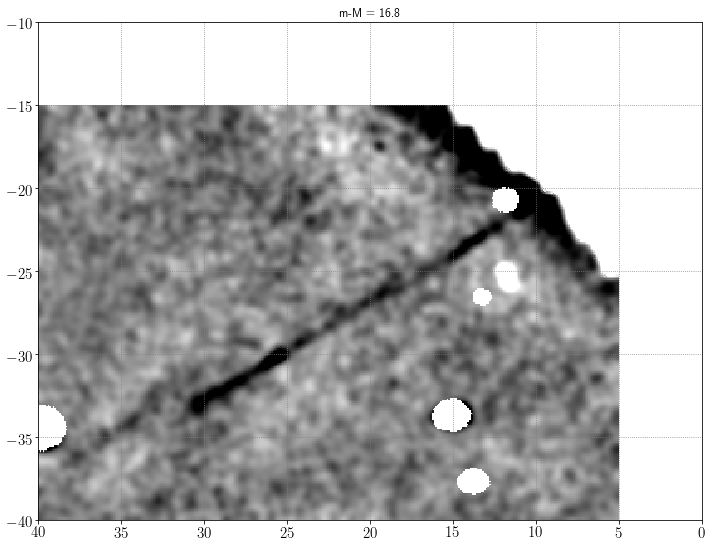

In [7]:
reload(region_plot)
%matplotlib inline
d = region_plot.prepare_hpxmap(16.8, hpxcube, fracdet, modulus)
xx,yy,vv = region_plot.run_atlas(d, dust=sfd, planck=planck, sigma = 0.25)
#plt.scatter(31, -33.2, s = 10, c='r')
#plt.scatter(12, -22, s = 10, c='r')
plt.title('m-M = 16.8')
plt.xlim(40,0)
plt.ylim(-40,-10)

/data/des81.b/data/tavangar/streams/code/region_plot.py:522: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  p1 = np.linspace(phi1min,phi1max,nphi1pix)
/data/des81.b/data/tavangar/streams/code/region_plot.py:523: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  p2 = np.linspace(phi2min,phi2max,nphi2pix)


5.0
(160, 117)


(-4, 4)

/home/s1/tavangar/.local/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/s1/tavangar/.local/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/s1/tavangar/.local/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


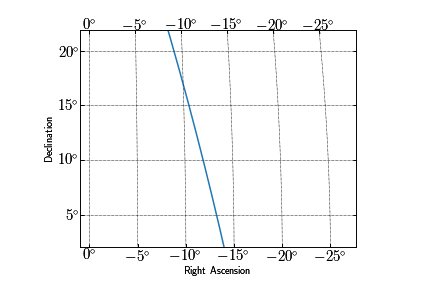

/home/s1/tavangar/.local/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


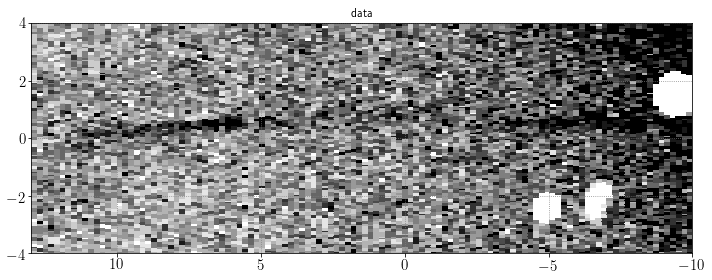

In [20]:
reload(region_plot)
d = region_plot.prepare_hpxmap(16.8, hpxcube, fracdet, modulus)
atlas_ends = [30.7, -33.2, 9.3, -20.9]   
pp1, pp2, vv, smooth_res, smooth, vv_mask, vv_mask_res = region_plot.stream_coord_spatial(d, atlas_ends, full_data, 
                                                                             deg=5, sigma=0.01, stream = 'Atlas')
np.save('model_arrays/pp1_full_atlas.npy', pp1)
np.save('model_arrays/pp2_full_atlas.npy', pp2)
#np.save('model_arrays/vv_full_atlas.npy', vv)
#np.save('model_arrays/smooth_res_full_atlas.npy', smooth_res)
#np.save('model_arrays/smooth_full_atlas.npy', smooth)
#plt.xlim(7.4, -9)
np.save('model_arrays/vv_mask_full_atlas.npy', vv_mask)
print(vv_mask.shape)
#plt.scatter(nodes, np.zeros(21),s = 3)
plt.ylim(-4,4)

(-66.05060964291059, -62.15427242448395)


(array([[nan, nan, 34., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, 34.],
        ...,
        [29., 27., 34., ..., 39., nan, nan],
        [nan, nan, nan, ..., 40., nan, nan],
        [39., nan, 37., ..., nan, nan, 38.]]),
 array([-10. ,  -9.8,  -9.6,  -9.4,  -9.2,  -9. ,  -8.8,  -8.6,  -8.4,
         -8.2,  -8. ,  -7.8,  -7.6,  -7.4,  -7.2,  -7. ,  -6.8,  -6.6,
         -6.4,  -6.2,  -6. ,  -5.8,  -5.6,  -5.4,  -5.2,  -5. ,  -4.8,
         -4.6,  -4.4,  -4.2,  -4. ,  -3.8,  -3.6,  -3.4,  -3.2,  -3. ,
         -2.8,  -2.6,  -2.4,  -2.2,  -2. ,  -1.8,  -1.6,  -1.4,  -1.2,
         -1. ,  -0.8,  -0.6,  -0.4,  -0.2,   0. ,   0.2,   0.4,   0.6,
          0.8,   1. ,   1.2,   1.4,   1.6,   1.8,   2. ,   2.2,   2.4,
          2.6,   2.8,   3. ,   3.2,   3.4,   3.6,   3.8,   4. ,   4.2,
          4.4,   4.6,   4.8,   5. ,   5.2,   5.4,   5.6,   5.8,   6. ,
          6.2,   6.4,   6.6,   6.8,   7. ,   7.2,   7.4,   7.6,   7.8,
     

/home/s1/tavangar/.local/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


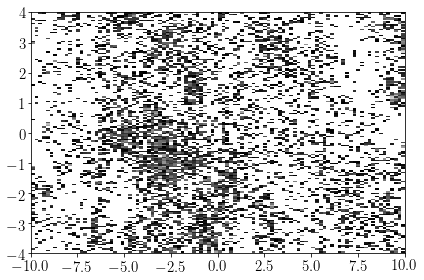

In [8]:
data = np.copy(full_data)

phi1, phi2, R = streamlib.rotation(atlas_ends, data['RA'], data['DEC'])
print(np.min(phi1), np.min(phi2))
plt.hist2d(phi1, phi2, bins=[100, 160], range=([-10,10], [-4,4]), cmax=40)